## Prerequisites

### Libraries

In [2]:
# For gee analyses
import ee 
import geemap.foliumap as geemap
from functions import *

# ee.Authenticate()
ee.Initialize()

# For plotting data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# For stats
from mlxtend.evaluate import mcnemar, mcnemar_table
%matplotlib inline

EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.

### Imports

In [3]:

# Import area of interest (AOI) IMPORTANT: keep the variable name to 'aoi' in order for the funcions to work
aoi = ee.FeatureCollection("projects/ee-nikolova100yana/assets/AOI_Salzachauen_buffer_150m_WGS84_33N")

# Insert list of desired image ids (or create your own collection). In this case an extensive list of ids is imported from functions.py
dates_list = import_dates_list()

# Import training and testing data (here we import data from GEE assets)
test_P = ee.FeatureCollection("projects/ee-nikolova100yana/assets/I3/Test_WGS33N_v3_gee")
train_P = ee.FeatureCollection("projects/ee-nikolova100yana/assets/I3/Train_WGS33N_v3_gee")

# State the name of the column containing label classes. In GEE classes have to be whole integers.
class_label = 'acronym_N' 

# Define the numeric and string variables of the landcover classes used
labels_str = ["PiAb", "PoBa", "FrEx", "AlIn", "QuRo", "AlGl", "SaAl"] 
labels_num = [1, 2, 3, 4, 5, 7, 8] 

# Filter training and testing data based on the provided classes
class_filter = ee.Filter.inList(class_label, labels_num)
train_P = train_P.filter(class_filter)
test_P = test_P.filter(class_filter)

## Create image collections and stacked images

### 1.1 Create image collection (with vegetation indeces) and a multitep. stacked image 

In [4]:
# Combine all the images you have imported into an image collection
imageCollection = ee.ImageCollection(dates_list) \
.select('B2', 'B3', 'B4','B5','B6','B7', 'B8A', 'B8', 'B11','B12')\
.map(lambda image: image.clip(aoi)) 

# print("Image collection", imageCollection.getInfo())

# Add vegetation indices bands to each image in the collection.
VegImageCollection = imageCollection.map(addIndices)
print("VegImageCOllection:", VegImageCollection.getInfo())

# # Apply the normalization to each image in the collection (optional)
# NormImageCollection = VegImageCollection.map(normalize)
# print("NormImageCollection", NormImageCollection.getInfo())

# Create a stack image for the image collection that includes vegetation indeces
# Stacking all images in the collection into one multi-band image
dates_img = collectionToStackImage(VegImageCollection)
print("stackedImage: ", dates_img.getInfo())



VegImageCOllection: {'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32633', 'crs_transform': [10, 0, 300000, 0, -10, 5400000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32633', 'crs_transform': [10, 0, 300000, 0, -10, 5400000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32633', 'crs_transform': [10, 0, 300000, 0, -10, 5400000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32633', 'crs_transform': [20, 0, 300000, 0, -20, 5400000]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 54

### 1.3 Create a multitemporal bands (STMs)

In [5]:
# STMs
# mean
mean = VegImageCollection.mean()
mean = stmRenameBands(mean, 'mean')

# median

median = VegImageCollection.median()
median = stmRenameBands(median,'median')
# variation
variation = VegImageCollection.reduce(ee.Reducer.variance())
variation = stmSwitchBands(variation)

# st_dev 
stddev = VegImageCollection.reduce(ee.Reducer.stdDev())
stddev = stmSwitchBands(stddev)

# q1 = ()
q1 = VegImageCollection.reduce(ee.Reducer.percentile([25]))  # 25th percentile
q1 = stmSwitchBands(q1)

# q2 = ()
q3 = VegImageCollection.reduce(ee.Reducer.percentile([75]))  # 75th percentile
q3 = stmSwitchBands(q3)

### Seasonal composites: spring, summer, autumn

In [6]:
# seasonal filters based on days of the year
spring_filter = ee.Filter.dayOfYear(108,140)
summer_filter = ee.Filter.dayOfYear(153,180)
autumn_filer = ee.Filter.dayOfYear(248,260)

# seasonal mean images 
spring = (VegImageCollection.filter(spring_filter)).mean()
summer = (VegImageCollection.filter(summer_filter)).mean()
autumn = (VegImageCollection.filter(autumn_filer)).mean()


seasonal_col = ee.ImageCollection([spring,summer, autumn])
# seasonalStackedImage = collectionToStackImage(seasonalCollection)

# Stacking all images in the collection into one multi-band image
seasonal_img = seasonal_col.toBands()

# Get the list of all band names
bandNames = seasonal_img.bandNames()
print('Original Band Names:', bandNames.getInfo())
print(len(bandNames.getInfo()))


Original Band Names: ['0_B2', '0_B3', '0_B4', '0_B5', '0_B6', '0_B7', '0_B8A', '0_B8', '0_B11', '0_B12', '0_ndvi', '0_greenness', '1_B2', '1_B3', '1_B4', '1_B5', '1_B6', '1_B7', '1_B8A', '1_B8', '1_B11', '1_B12', '1_ndvi', '1_greenness', '2_B2', '2_B3', '2_B4', '2_B5', '2_B6', '2_B7', '2_B8A', '2_B8', '2_B11', '2_B12', '2_ndvi', '2_greenness']
36


### Seasonal composite: spring and summer only

In [7]:
seasonal_col2 = ee.ImageCollection([spring,summer])
# seasonalStackedImage = collectionToStackImage(seasonalCollection)

# Stacking all images in the collection into one multi-band image
seasonal_img2 = seasonal_col2.toBands()

# Get the list of all band names
bandNames2 = seasonal_img2.bandNames()
print('Original Band Names:', bandNames2.getInfo())
print(len(bandNames2.getInfo()))

Original Band Names: ['0_B2', '0_B3', '0_B4', '0_B5', '0_B6', '0_B7', '0_B8A', '0_B8', '0_B11', '0_B12', '0_ndvi', '0_greenness', '1_B2', '1_B3', '1_B4', '1_B5', '1_B6', '1_B7', '1_B8A', '1_B8', '1_B11', '1_B12', '1_ndvi', '1_greenness']
24


### STM only

In [8]:
# stmStackedImage = ()
stm_col = ee.ImageCollection([mean,median, variation,stddev,q1,q3])
stm_img = stm_col.toBands()
stm_img = stmStackedBands(stm_img)
print(stm_img.bandNames().getInfo())


['mean_B2', 'mean_B3', 'mean_B4', 'mean_B5', 'mean_B6', 'mean_B7', 'mean_B8A', 'mean_B8', 'mean_B11', 'mean_B12', 'mean_ndvi', 'mean_greenness', 'median_B2', 'median_B3', 'median_B4', 'median_B5', 'median_B6', 'median_B7', 'median_B8A', 'median_B8', 'median_B11', 'median_B12', 'median_ndvi', 'median_greenness', 'variance_B2', 'variance_B3', 'variance_B4', 'variance_B5', 'variance_B6', 'variance_B7', 'variance_B8A', 'variance_B8', 'variance_B11', 'variance_B12', 'variance_ndvi', 'variance_greenness', 'stdDev_B2', 'stdDev_B3', 'stdDev_B4', 'stdDev_B5', 'stdDev_B6', 'stdDev_B7', 'stdDev_B8A', 'stdDev_B8', 'stdDev_B11', 'stdDev_B12', 'stdDev_ndvi', 'stdDev_greenness', 'p25_B2', 'p25_B3', 'p25_B4', 'p25_B5', 'p25_B6', 'p25_B7', 'p25_B8A', 'p25_B8', 'p25_B11', 'p25_B12', 'p25_ndvi', 'p25_greenness', 'p75_B2', 'p75_B3', 'p75_B4', 'p75_B5', 'p75_B6', 'p75_B7', 'p75_B8A', 'p75_B8', 'p75_B11', 'p75_B12', 'p75_ndvi', 'p75_greenness']


### Dates with STM

In [9]:
# stmStackedImage = ()
dates_with_stm_col = ee.ImageCollection([stm_img,dates_img])
dates_with_stm_img = dates_with_stm_col.toBands()
dates_with_stm_img = stmStackedBands(dates_with_stm_img)
print(dates_with_stm_img.bandNames().getInfo())


['mean_B2', 'mean_B3', 'mean_B4', 'mean_B5', 'mean_B6', 'mean_B7', 'mean_B8A', 'mean_B8', 'mean_B11', 'mean_B12', 'mean_ndvi', 'mean_greenness', 'median_B2', 'median_B3', 'median_B4', 'median_B5', 'median_B6', 'median_B7', 'median_B8A', 'median_B8', 'median_B11', 'median_B12', 'median_ndvi', 'median_greenness', 'variance_B2', 'variance_B3', 'variance_B4', 'variance_B5', 'variance_B6', 'variance_B7', 'variance_B8A', 'variance_B8', 'variance_B11', 'variance_B12', 'variance_ndvi', 'variance_greenness', 'stdDev_B2', 'stdDev_B3', 'stdDev_B4', 'stdDev_B5', 'stdDev_B6', 'stdDev_B7', 'stdDev_B8A', 'stdDev_B8', 'stdDev_B11', 'stdDev_B12', 'stdDev_ndvi', 'stdDev_greenness', 'p25_B2', 'p25_B3', 'p25_B4', 'p25_B5', 'p25_B6', 'p25_B7', 'p25_B8A', 'p25_B8', 'p25_B11', 'p25_B12', 'p25_ndvi', 'p25_greenness', 'p75_B2', 'p75_B3', 'p75_B4', 'p75_B5', 'p75_B6', 'p75_B7', 'p75_B8A', 'p75_B8', 'p75_B11', 'p75_B12', 'p75_ndvi', 'p75_greenness', '20200319_B2', '20200319_B3', '20200319_B4', '20200319_B5', '20

### Seasonal with STM

In [10]:
# stmStackedImage = ()
seasonal_with_stm_col = ee.ImageCollection([stm_img,seasonal_img])
seasonal_with_stm_img = seasonal_with_stm_col.toBands()
seasonal_with_stm_img = stmStackedBands(seasonal_with_stm_img)
print(seasonal_with_stm_img.bandNames().getInfo())

['mean_B2', 'mean_B3', 'mean_B4', 'mean_B5', 'mean_B6', 'mean_B7', 'mean_B8A', 'mean_B8', 'mean_B11', 'mean_B12', 'mean_ndvi', 'mean_greenness', 'median_B2', 'median_B3', 'median_B4', 'median_B5', 'median_B6', 'median_B7', 'median_B8A', 'median_B8', 'median_B11', 'median_B12', 'median_ndvi', 'median_greenness', 'variance_B2', 'variance_B3', 'variance_B4', 'variance_B5', 'variance_B6', 'variance_B7', 'variance_B8A', 'variance_B8', 'variance_B11', 'variance_B12', 'variance_ndvi', 'variance_greenness', 'stdDev_B2', 'stdDev_B3', 'stdDev_B4', 'stdDev_B5', 'stdDev_B6', 'stdDev_B7', 'stdDev_B8A', 'stdDev_B8', 'stdDev_B11', 'stdDev_B12', 'stdDev_ndvi', 'stdDev_greenness', 'p25_B2', 'p25_B3', 'p25_B4', 'p25_B5', 'p25_B6', 'p25_B7', 'p25_B8A', 'p25_B8', 'p25_B11', 'p25_B12', 'p25_ndvi', 'p25_greenness', 'p75_B2', 'p75_B3', 'p75_B4', 'p75_B5', 'p75_B6', 'p75_B7', 'p75_B8A', 'p75_B8', 'p75_B11', 'p75_B12', 'p75_ndvi', 'p75_greenness', '0_B2', '0_B3', '0_B4', '0_B5', '0_B6', '0_B7', '0_B8A', '0_B8'

## Visualize the data

In this case we will explore the data using the two vegetation indeces

In [ ]:
# Create a multitemporal image of singel index
ndvi_stackedImage = dates_img.select(['.*_ndvi']) #'.*_greenness']
greenness_stackedImage = dates_img.select(['.*_greenness'])

# Create panda dataframe for trining points based on the multitemporal image
ndvi_df = create_pd_df(ndvi_stackedImage, train_P, class_label)
# print(ndvi_df.head())

greenness_df = create_pd_df(greenness_stackedImage, train_P, class_label)
# print(greenness_df.head())


In [ ]:
# Create a dictionary where each numeric label (key) is paired with each string label
label_map = {labels_num[i]:labels_str[i] for i in range (len(labels_num))}
print ("Resulting class dictionary is: " + str(label_map))

# Create an array with the colors you want to use
custom_palette = ["#2A4000", "#E69800", "#8400A8", "#4CE600", "#FF73DF", "#FFFF00", "#00FFC5"]
label_color_map = {labels_str[i]:custom_palette[i] for i in range (len(labels_str))}
print("Custom colour map legend: " + str(label_color_map))

In [ ]:

# plot_timeseries1(greenness_df,label_map, label_color_map,'Greenness')
plot_timeseries(ndvi_df,label_map, label_color_map,'NDVI')

In [ ]:
plot_timeseries(greenness_df,label_map, label_color_map,'NDVI')

### Band Value distribution with subplots for each cpecies

In [ ]:
# %matplotlib inline

df = ndvi_df
# Map your original labels to custom labels
df['Tree Species'] = df['label'].map(label_map)

g = sns.FacetGrid(df, col="Tree Species",hue="Tree Species", col_wrap=4,palette="tab10" )
g.set_titles(col_template="{col_name}")
g.map(sns.kdeplot, "values", fill=True)
g.set_xlabels('NDVI')  # Custom x-axis title


### Timeseries visualization with subplots for each cpecies

In [ ]:
# sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
    
# Create a FacetGrid with lineplots
g = sns.FacetGrid(df, col="Tree Species", hue="Tree Species", col_wrap=4, palette="tab10")

# Set titles for each facet
g.set_titles(col_template="{col_name}")

# Map lineplot for each facet
g.map(sns.lineplot, "date_str", "values")

# Remove x-tick labels from all subplots (remove ticks from x-axis)
g.set(xticks=[])

# Edit x-axis title for all facets (this will be shared for all subplots)
g.set_xlabels('Date')  # Custom x-axis title
g.set_ylabels('Greenness')  # Custom x-axis title


# Display the plot
plt.show()

### Plot NDVI vs Greenness

In [ ]:
# Rename the 'value' column to 'ndvi' in df1 and 'greenness' in df2
ndvi_df.rename(columns={'values': 'ndvi'}, inplace=True)

greenness_df.rename(columns={'values': 'greenness'}, inplace=True)
merged_df = pd.merge(ndvi_df,greenness_df, left_index=True, right_index=True)
# print(merged_df.head())



In [ ]:
sns.jointplot(data=merged_df, x="greenness", y="ndvi", hue="Tree Species_x", palette=label_color_map)

## 2. Train and Apply RF Models
### 2.1 Stacked Image classification

In [11]:

# 1. Choose a composite (stacked multitemporal image)on which classification to be done
# composite1 = dates_img
# composite2 = seasonal_img
# composite3 = stm_img
# composite = dates_with_stm_img
# composite = seasonal_with_stm_img

composites = [dates_img, seasonal_img, stm_img]

# Initialize lists to store results
classified_images = []
classifiers = []

for composite in composites:
    classified,classifier = random_forest_classification(composite,train_P,class_label)
    classified_images.append(classified)
    classifiers.append(classifier)

# 1. multi-date classification, 2. seasonal classification, 3. STMs
classified1, classified2, classified3 = classified_images
classifier1, classifier2, classifier3 = classifiers

# ------------------------------------------------------------------------------------------


# Export the classified image

# aoi = aoi.geometry()

# geemap.ee_export_image(
#     classified, filename="seasonal_img_01022025.tif", scale=10,region = aoi, file_per_band=False,  
# )



In [ ]:

m = geemap.Map()

palette = ['4682b4', '32cd32', '800080', 'ffa500', 'ff6347', '40e0d0'] #'ee82ee', # Violet#'f5deb3'  # Wheat]
m.addLayer(classified2, {'min': 0, 'max': 7, 'palette': palette}, '2020')

m.centerObject(aoi,12)
m

### 3 Confusion matrix

In [12]:
# Initialize lists which will contain all confusion matrixes and classified test data obtianed from the RF models
conf_list = []
test_list = []

for classified_image in [classified1, classified2, classified3]:
    eeConfusionMatrix, test = accuracy_assesment(
        classified_image=classified_image,
        testing_data=test_P,
        class_label=class_label,
        order=labels_num
    )
    conf_list.append(eeConfusionMatrix)
    test_list.append(test)

#------------------------------------------------------------------------------------------
# Unpack the results into individual variables
# 1:multi-date classification, 2:seasonal classification, 3:STMs
eeConfusionMatrix1, eeConfusionMatrix2, eeConfusionMatrix3 = conf_list
test1, test2, test3 = test_list

# to get accuracies do this
# ConfusionMatrix = eeConfusionMatrix.getInfo()
# overallaccuracy = eeConfusionMatrix.accuracy().getInfo()
# fscore = eeConfusionMatrix.fscore().getInfo()

In [ ]:
# Plot COnfusion matrix of all three classifieres
for confusion_matrix,title in zip(conf_list,["Multi-date classification", "Mean seasonal classification","STMs classificaton"]):
    plot_confmatrix(confusion_matrix, labels_str, title)

## Stats (McNemar's Test)

In [63]:
display(test_P)
display(test1)
display(test2)

In [77]:
# Filter the FeatureCollection where the 'acronym_N' property equals 1
for selected_class in [1,2,4,8]:
    test1_filtered = test1.filter(ee.Filter.eq('acronym_N', selected_class))
    test2_filtered = test2.filter(ee.Filter.eq('acronym_N', selected_class))
    test3_filtered = test3.filter(ee.Filter.eq('acronym_N', selected_class))

    # Workflow 
    print("Selected Class:", selected_class)

    # The correct target (class) labels
    y_target = test1_filtered.aggregate_array('acronym_N')  # True labels
    y_target = np.array(y_target.getInfo())
    print(y_target)

    # Class labels predicted by model 1
    y_model1 = test1_filtered.aggregate_array('classification')
    y_model1 = np.array(y_model1.getInfo())
    print(y_model1)

    # Class labels predicted by model 2
    y_model2 = test2_filtered.aggregate_array('classification')
    y_model2 = np.array(y_model2.getInfo())
    print(y_model2)

    # Class labels predicted by model 2
    y_model3 = test3_filtered.aggregate_array('classification')
    y_model3 = np.array(y_model3.getInfo())
    print(y_model3)

    # Verify the lengths of the arrays
    print("Verify the lengths of the arrays",len(y_target), len(y_model1), len(y_model2),len(y_model3))

    tb1 = mcnemar_table(y_target, y_model1, y_model2) # multi-date vs seasonal
    tb2 = mcnemar_table(y_target, y_model1, y_model3) # multi-date vs stm
    tb3 = mcnemar_table(y_target, y_model3, y_model2) # stn vs seasonal

    display(tb1)
    display(tb2)
    display(tb3)

    # Perform McNemar's test for all tables
    for i, tb in enumerate([tb1, tb2, tb3], 1):
        chi2, p = mcnemar(ary=tb, exact=True)
        print(f"Table {i} - Chi-squared: {chi2}, p-value: {p}")

    



Selected Class: 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Verify the lengths of the arrays 21 21 21 21


array([[20,  0],
       [ 0,  1]])

array([[20,  0],
       [ 0,  1]])

array([[20,  0],
       [ 0,  1]])

Table 1 - Chi-squared: None, p-value: 1.0
Table 2 - Chi-squared: None, p-value: 1.0
Table 3 - Chi-squared: None, p-value: 1.0
Selected Class: 2
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 4 2 1 2 2 2 3 7 1 7 2 5]
[2 2 2 2 2 2 2 2 1 2 2 2 3 2 2 2 2 5]
[2 2 2 2 2 2 2 2 8 2 2 2 5 2 2 2 2 5]
Verify the lengths of the arrays 18 18 18 18


array([[11,  0],
       [ 4,  3]])

array([[11,  0],
       [ 4,  3]])

array([[15,  0],
       [ 0,  3]])

Table 1 - Chi-squared: None, p-value: 0.125
Table 2 - Chi-squared: None, p-value: 0.125
Table 3 - Chi-squared: None, p-value: 1.0
Selected Class: 4
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4 4 4 4 4 4 4 4 4 7 3 3 3 7 4 8 2 4 3 3 4 4]
[4 4 3 4 4 4 4 4 4 7 4 3 7 4 4 8 7 4 5 3 4 4]
[4 4 4 4 4 4 4 4 4 7 3 3 4 4 4 3 7 4 3 3 3 3]
Verify the lengths of the arrays 22 22 22 22


array([[12,  1],
       [ 2,  7]])

array([[11,  2],
       [ 2,  7]])

array([[11,  2],
       [ 3,  6]])

Table 1 - Chi-squared: None, p-value: 1.0
Table 2 - Chi-squared: None, p-value: 1.0
Table 3 - Chi-squared: None, p-value: 1.0
Selected Class: 8
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5]
[8 8 8 8 8 8 3 8 8 8 5 5 8 8 8 8 8 8 8 5]
[8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 5]
Verify the lengths of the arrays 20 20 20 20


array([[16,  3],
       [ 0,  1]])

array([[18,  1],
       [ 0,  1]])

array([[16,  2],
       [ 0,  2]])

Table 1 - Chi-squared: None, p-value: 0.25
Table 2 - Chi-squared: None, p-value: 1.0
Table 3 - Chi-squared: None, p-value: 0.5


In [79]:
# Workflow for all species accuracies
# The correct target (class) labels
y_target = test1.aggregate_array('acronym_N')  # True labels
y_target = np.array(y_target.getInfo())
print(y_target)

# Class labels predicted by model 1
y_model1 = test1.aggregate_array('classification')
y_model1 = np.array(y_model1.getInfo())
print(y_model1)

# Class labels predicted by model 2
y_model2 = test2.aggregate_array('classification')
y_model2 = np.array(y_model2.getInfo())

# Class labels predicted by model 2
y_model3 = test3.aggregate_array('classification')
y_model3 = np.array(y_model3.getInfo())

[2 2 2 2 2 2 2 2 1 1 1 1 8 8 8 8 8 1 1 4 4 4 4 4 4 4 4 4 7 7 7 7 8 5 5 5 8
 8 5 5 5 5 3 3 8 8 8 8 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 8 8 8 5 5
 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
[2 2 2 2 2 2 4 2 1 1 1 3 8 8 8 8 8 1 1 4 4 4 4 4 4 4 4 4 3 7 7 7 8 2 5 3 8
 8 5 7 5 5 3 3 8 8 8 8 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1 1 1 5 1 5 1 8 8 5 5 5
 5 5 5 1 3 3 1 2 2 2 3 7 1 7 2 5 1 1 1 5 3 2 2 4 3 3 8 7 3 8 5 5 4 7 3 3 3
 7 4 8 2 4 3 3 4 4 5 5 5 7 7 8 1 5 1 5 3 8 5]


One-vs-Rest Transformation: For each class 𝐶𝑖 (1 through 8):Treat 𝐶𝑖 as the positive class.
Treat all other classes as the negative class.Compare the models' classifications for cases where 𝐶𝑖 is not the true label (negative cases).

In [ ]:
# Specify the classes you want to analyze
selected_classes = [1, 2, 4, 8]  # Example: Only these classes

# Function remains unchanged
def sensitivity_contingency_matrix_multi_class(y_target, y_model1, y_model2, class_labels):
    results = {}
    
    for cls in class_labels:
        # Step 1: One-vs-Rest Transformation
        # Positive cases for class `cls` are where y_target == cls
        positive_indices = np.where(y_target == cls)[0]  # Indices where the true class is `cls`
        
        # Subset the arrays for positive cases
        y_model1_pos = y_model1[positive_indices]
        y_model2_pos = y_model2[positive_indices]
        y_target_pos = y_target[positive_indices]
        
        # Step 2: Construct Contingency Matrix for Sensitivity
        a = np.sum((y_model1_pos == cls) & (y_model2_pos == cls))  # Both agree on True Positives
        b = np.sum((y_model1_pos == cls) & (y_model2_pos != cls))  # Model 1 correct, Model 2 incorrect
        c = np.sum((y_model1_pos != cls) & (y_model2_pos == cls))  # Model 1 incorrect, Model 2 correct
        d = np.sum((y_model1_pos != cls) & (y_model2_pos != cls))  # Both incorrect
        
        # Store the contingency matrix for this class
        results[cls] = np.array([[a, b], [c, d]])
    
    return results
# ------------------------------------------------------------------------------------------
def specificity_contingency_matrix_multi_class(y_target, y_model1, y_model2, class_labels):
    results = {}
    
    for cls in class_labels:
        # Step 1: One-vs-Rest Transformation
        # True negatives for class `cls` are cases where y_target != cls
        non_cls_indices = np.where(y_target != cls)[0]  # Indices where the true class is NOT `cls`
        
        # Subset the arrays for negative cases
        y_model1_neg = y_model1[non_cls_indices]
        y_model2_neg = y_model2[non_cls_indices]
        y_target_neg = y_target[non_cls_indices]
        
        # Step 2: Construct Contingency Matrix for Specificity
        a = np.sum((y_model1_neg != cls) & (y_model2_neg != cls))  # Both agree on True Negatives
        b = np.sum((y_model1_neg != cls) & (y_model2_neg == cls))  # Model 1 correct, Model 2 incorrect
        c = np.sum((y_model1_neg == cls) & (y_model2_neg != cls))  # Model 1 incorrect, Model 2 correct
        d = np.sum((y_model1_neg == cls) & (y_model2_neg == cls))  # Both incorrect
        
        # Store the contingency matrix for this class
        results[cls] = np.array([[a, b], [c, d]])
    
    return results




### Species Specificity Compare

In [88]:
# Compute contingency matrices for specificity
specificity_matrices = specificity_contingency_matrix_multi_class(y_target, y_model2, y_model3, selected_classes)

# Display and analyze the results for the selected classes
for cls in selected_classes:
    matrix = specificity_matrices[cls]
    print(f"Contingency Matrix for Specificity (Class {cls}):")
    print(matrix)
    
    # Perform McNemar's test
    chi2, p = mcnemar(ary=matrix, exact=True, corrected=True)
    print(f"Class {cls} - Chi-squared: {chi2}, p-value: {p}")
    print()

Contingency Matrix for Specificity (Class 1):
[[106   0]
 [  5   1]]
Class 1 - Chi-squared: None, p-value: 0.0625

Contingency Matrix for Specificity (Class 2):
[[107   5]
 [  1   2]]
Class 2 - Chi-squared: None, p-value: 0.21875

Contingency Matrix for Specificity (Class 4):
[[102   8]
 [  0   1]]
Class 4 - Chi-squared: None, p-value: 0.0078125

Contingency Matrix for Specificity (Class 8):
[[102   3]
 [  1   7]]
Class 8 - Chi-squared: None, p-value: 0.625



### Species Sensitivity Compare

In [ ]:

# Compute contingency matrices for sensitivity for selected classes
sensitivity_matrices = sensitivity_contingency_matrix_multi_class(
    y_target, y_model1, y_model2, selected_classes
)

# Display and analyze the results for the selected classes
for cls in selected_classes:
    matrix = sensitivity_matrices[cls]
    print(f"Contingency Matrix for Sensitivity (Class {cls}):")
    print(matrix)
    
    # Perform McNemar's test
    chi2, p = mcnemar(ary=matrix, exact=True)
    print(f"Class {cls} - Chi-squared: {chi2}, p-value: {p}")
    print()

Contingency Matrix for Sensitivity (Class 1):
[[20  0]
 [ 0  1]]
Class 1 - Chi-squared: None, p-value: 1.0

Contingency Matrix for Sensitivity (Class 2):
[[11  0]
 [ 4  3]]
Class 2 - Chi-squared: None, p-value: 0.125

Contingency Matrix for Sensitivity (Class 4):
[[12  1]
 [ 2  7]]
Class 4 - Chi-squared: None, p-value: 1.0

Contingency Matrix for Sensitivity (Class 8):
[[16  3]
 [ 0  1]]
Class 8 - Chi-squared: None, p-value: 0.25



In [90]:
# Example: Define the class labels (1 through 8 in your case)
class_labels = [1,2,3,4,5,7,8]  # Replace with the actual classes in your dataset

# Initialize counters for the 2x2 contingency table
a = b = c = d = 0

# Loop through each class and calculate the overall specificity contingency table
for cls in class_labels:
    # Negative cases are where y_target != cls
    negative_indices = np.where(y_target != cls)[0]
    
    # Subset the arrays for negative cases
    y_model1_neg = y_model2[negative_indices]
    y_model2_neg = y_model3[negative_indices]
    
    # Update the counts for the contingency table based on model predictions
    a += np.sum((y_model1_neg != cls) & (y_model2_neg != cls))  # Both agree on True Negatives
    b += np.sum((y_model1_neg == cls) & (y_model2_neg != cls))  # Model 1 incorrect, Model 2 correct
    c += np.sum((y_model1_neg != cls) & (y_model2_neg == cls))  # Model 1 correct, Model 2 incorrect
    d += np.sum((y_model1_neg == cls) & (y_model2_neg == cls))  # Both incorrect

# Construct the overall specificity contingency table
specificity_table = np.array([[a, b], [c, d]])

# Display the overall specificity contingency table
print(f"Overall Specificity Contingency Table:\n{specificity_table}")

# Perform McNemar's test on the overall specificity table
chi2, p = mcnemar(ary=specificity_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

Overall Specificity Contingency Table:
[[726  22]
 [ 25  25]]
Chi-squared: 0.0851063829787234, p-value: 0.7704930827944241


In [61]:


# Verify the lengths of the arrays
print(len(y_target), len(y_model1), len(y_model2))

tb1 = mcnemar_table(y_target, y_model1, y_model2) # multi-date vs seasonal
tb2 = mcnemar_table(y_target, y_model1, y_model3) # multi-date vs stm
tb3 = mcnemar_table(y_target, y_model3, y_model2) # stn vs seasonal
print(tb1)
print(tb2)
print(tb3)

# Perform McNemar's test for all tables
for i, tb in enumerate([tb1, tb2, tb3], 1):
    chi2, p = mcnemar(ary=tb, corrected=False)
    print(f"Table {i} - Chi-squared: {chi2:.3f}, p-value: {p:.3f}")



133 133 133
[[76  9]
 [10 38]]
[[74 11]
 [ 9 39]]
[[74  9]
 [12 38]]
chi-squared: 0.429
p-value: 0.513
Table 1 - Chi-squared: 0.053, p-value: 0.819
Table 2 - Chi-squared: 0.200, p-value: 0.655
Table 3 - Chi-squared: 0.429, p-value: 0.513


In [33]:
# ConfusionMatrix, overallaccuracy, fscore = accuracy_assesment(
#     classified_image= classified, 
#     testing_data= test_P, 
#     class_label= class_label, 
#     order= labels_num
#     )

# # Printing of confusion matrix and accuracy
# print('Confusion Matrix:', ConfusionMatrix)
# print('Overall Accuracy:', overallaccuracy)
# print('FScore:', fscore)
# print('Producers Accuracy:', producer)
# print('Consumers accuracy:',consumer)
# #----------------------------------------------------

# plot_confmatrix(ConfusionMatrix,labels_str,overallaccuracy)

# fscore_multitemp = dict(zip(labels_str,fscore))

# multitemp_accuracy = {
#     'Overall Accuracy': overallaccuracy,
#     **fscore_multitemp
# }


# df_mulittemp = pd.DataFrame(multitemp_accuracy, index=[0]).round(2)
# df_mulittemp



### Feature Importance

In [34]:
# 5. Plot Feature Importance into a heatmap
band_order = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','greenness','ndvi']
width = 12.8 
height =  6.8



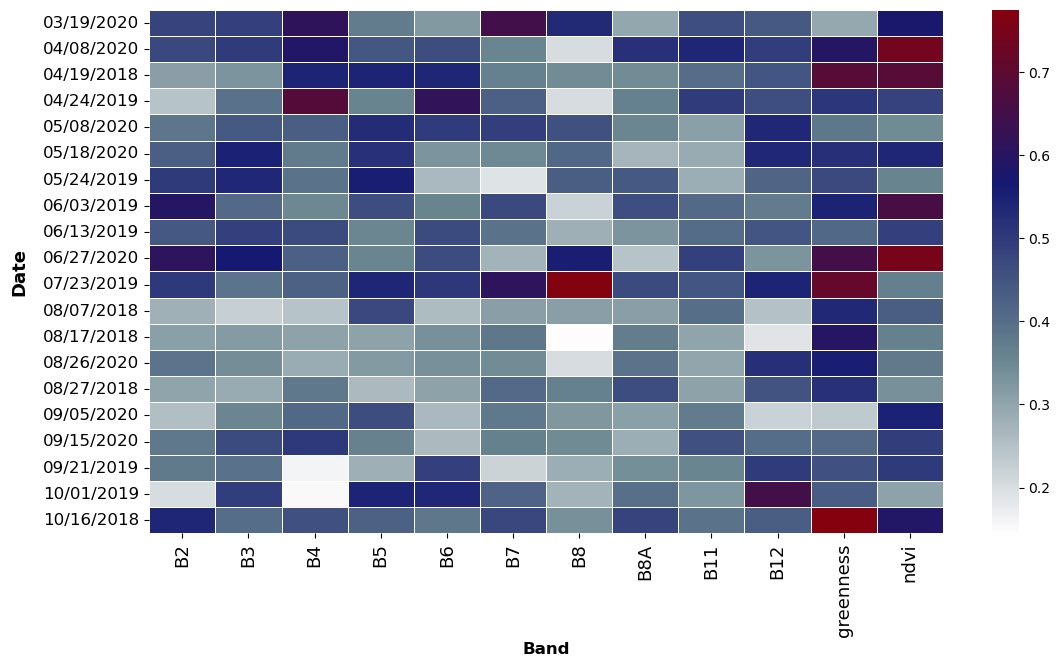

Top 10 Most Important Bands


,Date id,Band,Importance
58,10/16/2018,greenness,0.774663
116,07/23/2019,B8,0.768624
203,06/27/2020,ndvi,0.748257
167,04/08/2020,ndvi,0.738923
118,07/23/2019,greenness,0.714424
11,04/19/2018,ndvi,0.688336
10,04/19/2018,greenness,0.687564
64,04/24/2019,B4,0.683212
95,06/03/2019,ndvi,0.660796
202,06/27/2020,greenness,0.652143


In [35]:
data_importance = plot_importance( classifier1, band_order, width, height)

## 2.2 Single image classification

In [ ]:
# # 1. Choose a composite (stacked multitemporal image)on which classification to be done
# composite = stackedImage

#----------------------------------------------------------------------
#Display the chosen range of images from the sorted cloud collection
image_collection_list = VegImageCollection.toList(VegImageCollection.size())

# Get the size of the collection
collection_size = image_collection_list.size().getInfo()

# Here is an empty dictionary which will collect all the accuracies for each single date
single_date_accuracy = []

# Loop over the indices
for i in range(collection_size):
    image = ee.Image(image_collection_list.get(i))  # Get the image at index i
    date_str = image.date().format('MM/dd/yyyy').getInfo()  # Extract the date
    date_int = int(image.date().format('MMddyyyy').getInfo())
    classified, classifier = random_forest_classification(image, train_P, class_label)

    ConfusionMatrix, overallaccuracy, fscore = accuracy_assesment(
        classified_image= classified, 
        testing_data= test_P, 
        class_label= class_label, 
        order= labels_num
        )

    fscore_species = dict(zip(labels_str,fscore))

    single_date_entry = {
        'date_int': date_int,
        'Date': date_str,
        'Overall Accuracy': overallaccuracy,
        **fscore_species
    }

    single_date_accuracy.append(single_date_entry)

df3 = pd.DataFrame(single_date_accuracy)
df3